In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [3]:
def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    # returnSignal[returnSignal < 0] = 0
    # returnSignal[returnSignal > 255] = 255

    return returnSignal

    
def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs

def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def getDerivatives(img, sigma):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    Ixx = partialDerivative(np.copy(Ix), sigma)
    Iyy = partialDerivative(np.copy(Iy.T), sigma).T
    Ixy = partialDerivative(np.copy(Ix.T), sigma).T
    return Ix,Iy,Ixx,Iyy,Ixy

def gradient_magnitude(img):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 1)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Ix,Iy)
    return magnitude, angle

# Exercise 2

### a

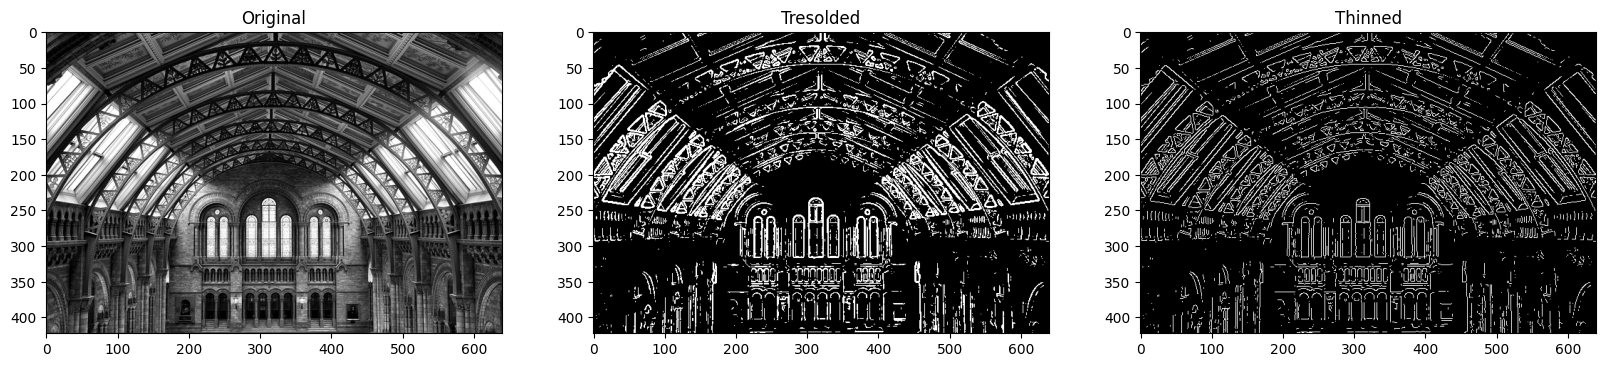

In [44]:
def findedges(img, sigma, theta):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Iy,Ix)
    Ie = np.copy(magnitude)
    Ie[magnitude >= theta] = 1
    Ie[magnitude < theta] = 0
    Iee = np.copy(Ie)
    for y, row in enumerate(Ie):
        for x, pixel in enumerate(row):
            a = angle[y,x]
            yy = int(np.round(np.sin(a)))
            xx = int(np.round(np.cos(a)))
            if y + yy > 0 and x + xx > 0 and y + yy < len(magnitude) and x + xx < len(magnitude[y]) and y - yy > 0 and x - xx > 0 and y - yy < len(magnitude) and x - xx < len(magnitude[y]):
                if magnitude[y+yy, x+xx] > magnitude[y, x] or magnitude[y-yy, x-xx] > magnitude[y, x]:
                    Iee[y,x] = 0
    return Ie, Iee

temp = cv2.imread('images/museum.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64)
# temp = temp[200:350,200:500]
Ie, Iee = findedges(temp, 1, 40)
# Ie, Iee = findedges(temp, 1, 30)

f = plt.figure(figsize=(20, 8))
f.add_subplot(1, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("Original")
f.add_subplot(1, 3, 2)
plt.imshow(Ie, cmap="gray")
plt.title("Tresolded")
f.add_subplot(1, 3, 3)
plt.imshow(Iee, cmap="gray")
plt.title("Thinned")
plt.show()